Author of notebook: Mirjam Koedijk

Date of latest update: 02/07/2025.

In [1]:
import h5py
import numpy as np
import sys
import pandas as pd
import os
import matplotlib.pyplot as plt
import json
import time
import scipy.sparse as sp
import math
import scipy.io
import numpy.ma as ma
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from scipy.spatial.distance import pdist
from numba import jit, prange
from scipy import integrate
from scipy.linalg import expm
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cluster import MiniBatchKMeans
from scipy.integrate import solve_ivp
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from types import SimpleNamespace
from scipy.io import loadmat

In [2]:
plt.style.use('seaborn-v0_8-bright')
plt.rcParams.update({'font.size': 12})

# Data-driven version of Lyapunov spectrum
### Order of implementation
1. Load and prepare data
2. Defining functions for building delay-matrix and calculating entropy
3. Determine number of partitions and delays
4. Perform dimension eduction
5. Define functions for Jacobian estimation and Lyapunov spectrum
6. Calculate Lyapunov spectrum

## 1. Load data
The data comes from running the Morrison-Young model on 6 different Atanas data sets. The model is solved using an ivp-solver, which is why we get a $y$ file as output and a $t$ file.

In [3]:
# Data retrieved from running the model for D, D2, ..., D6.
data1 = np.load('Data/solution1.npz')
t1 = data1['t']
y1 = data1['y']

data2 = np.load('Data/solution2.npz')
t2 = data2['t']
y2 = data2['y']

data3 = np.load('Data/solution3.npz')
t3 = data3['t']
y3 = data3['y']

data4 = np.load('Data/solution4.npz')
t4 = data4['t']
y4 = data4['y']

data5 = np.load('Data/solution5.npz')
t5 = data5['t']
y5 = data5['y']

data6 = np.load('Data/solution6.npz')
t6 = data6['t']
y6 = data6['y']

datasets = [y1, y2, y3, y4, y5, y6]

timesets = [t1, t2, t3, t4, t5, t6]

nIDs_all_worms = ["AVBL","AVBR","RIBL","RIBR","RID", "AVDL", "AVDR", "AVAL", "AVAR", "RIML", "RIMR","AVEL","AVER",
                "AIBL","AIBR"]
new_dt = 0.01 # Average time_step for Atanas data

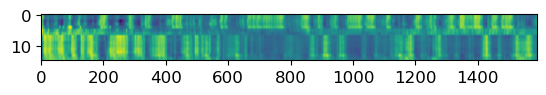

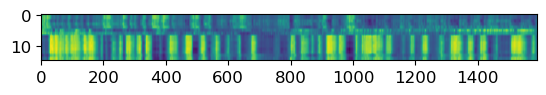

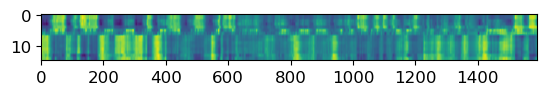

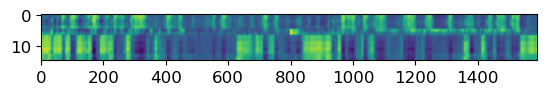

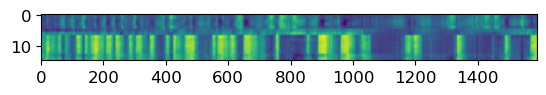

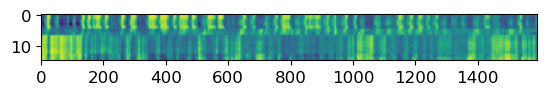

In [4]:
# Show time series for every dataset
for dataset in datasets:
    plt.imshow(dataset, cmap='viridis', aspect=10)
    plt.show()

Here we also check whether the data has missing or invalid entries. Since the data comes from running the model with an IVP-solver there will probably be no such values.

In [5]:
# Check whether there are missing or invalid entries in the datasets
for i, data in enumerate(datasets):
    if np.ma.isMaskedArray(data):
        print(f"Dataset {i+1} is a masked array with {np.ma.count_masked(data)} masked entries.")
    elif np.isnan(data).any():
        print(f"Dataset {i+1} contains NaNs.")
    else:
        print(f"Dataset {i+1} looks clean.")

Dataset 1 looks clean.
Dataset 2 looks clean.
Dataset 3 looks clean.
Dataset 4 looks clean.
Dataset 5 looks clean.
Dataset 6 looks clean.


We append the data to each other, where after every dataset a row of zeros is added.

(6, 1592, 15)
(9552, 15)


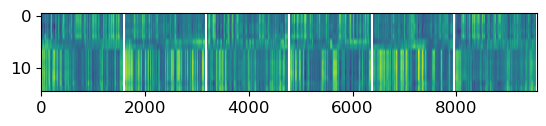

In [6]:
# append the datasets with a stacked row of zeros
Xa = []
for k in range(6):
    Xa.append(ma.vstack([datasets[k].T,np.zeros(15)]))
print(np.shape(Xa)) # 6 worms, 1592 data points for 15 neurons

# stack the datapoints of the worms to each other, we get an array where the timeseries are added to each other
Xa_all = ma.vstack(Xa)
Xa_all[Xa_all==0] = ma.masked
print(np.shape(Xa_all)) # 6*1592 = 9552 data points for 15 neurons

plt.imshow(Xa_all.T, cmap='viridis', aspect=100)
plt.show()

## 2. Defining functions for building delay-matrix and calculating entropy

In [7]:
##############################################
### Functions for building the delay-matrix ##
##############################################
def segment_maskedArray(tseries,min_size=50):
    '''
    Segments time series into segments with no invalid entries, outputs only segments who are at least of length min_size. 
    The output will be a list of [start_idx, end_idx] for every segment.
    '''
    # Turns invalid values into masked values, if that was not done already
    if ~np.ma.isMaskedArray(tseries):
        tseries = ma.masked_invalid(tseries)
    
    # If tseries higher dimensional, checks whether any column in a row is masked
    if len(tseries.shape)>1:
        mask = ~np.any(tseries.mask,axis=1)
    else:
        mask = ~tseries.mask
    
    # Finds the segments of valid entries by having (start, end) of segment as output
    segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)
    
    # Filters out segments that are too small
    segs_ = []
    for t0,tf in segments:
        if tf-t0>min_size:
            segs_.append([t0,tf])
    # Output
    segments = np.vstack(segs_)
    
    return segments

@jit(nopython=True)
def tm_seg(X,K):
    '''
    Build a trajectory matrix, for a segment of a timeseries with no invalid values or missing entries.
    X: N x dim data
    K: the number of delays
    N: numnber of timesteps
    out: (N-K)x(dim*K) dimensional
    '''
    tm=np.zeros(((len(X)-K-1),X.shape[1]*(K+1)))
    for t in range(len(X)-K-1):
        x = X[t:t+K+1,:][::-1]
        x_flat = x.flatten()
        tm[t] = x_flat
    return tm

# trajectory matrix = matrix with added delays K.
def trajectory_matrix(X,K):
    """
    Build a trajectory matrix, for an entire dataset even when it has invalid values or missing entries.
    X: N x dim data
    K: the number of delays
    N: number of timesteps
    out: (N-K)x(dim*K) dimensional
    """
    min_seg=K+1
    segments = segment_maskedArray(X,min_seg)
    traj_matrix = ma.zeros((len(X),X.shape[1]*(K+1)))
    for t0,tf in segments:
        traj_matrix[t0+int(np.floor(K/2)):tf-int(np.ceil(K/2)+1)] = ma.masked_invalid(tm_seg(ma.filled(X[t0:tf],np.nan),K))
    traj_matrix[traj_matrix==0]=ma.masked
    return traj_matrix

#########################################
### Functions for calculating entropy ###
#########################################
def compute_transition_matrix(time_series):
    """
    Function that computes the transition matrix; a matrix that holds the probabilities of transitioning from one state to
    another, for every state possible.
    """
    # Get unique states in the time series
    states = np.unique(time_series)
    num_states = len(states)
    
    # Initialize the transition matrix
    transition_matrix = np.zeros((num_states, num_states), dtype=float)
    
    # Create a mapping from state to index
    state_to_index = {state: index for index, state in enumerate(states)}
    
    # Count transitions
    for (current_state, next_state) in zip(time_series[:-1], time_series[1:]):
        current_index = state_to_index[current_state]
        next_index = state_to_index[next_state]
        transition_matrix[current_index, next_index] += 1
    
    # Normalize rows to get probabilities
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    transition_matrix = np.divide(transition_matrix, row_sums, where=row_sums!=0)
    
    return transition_matrix
    
def compute_stationary_distribution(transition_matrix):
    """
    Finds the stationary distribution: where you are most likely to be if you follow the tranisition matrix "forever".
    """
    # Eigenvalue decomposition
    eigenvalues, eigenvectors = np.linalg.eig(transition_matrix.T)
    
    # Find the eigenvector associated with eigenvalue 1
    stationary_vector = eigenvectors[:, np.isclose(eigenvalues, 1)]
    
    # Normalize the vector to get probabilities
    stationary_distribution = stationary_vector[:, 0].real
    stationary_distribution /= stationary_distribution.sum()
    
    return stationary_distribution

def perform_kmeans_clustering(data, n_clusters, max_iters=100):
    """
    Performs k-means clustering without using kmeans.
    """
    # Randomly initialize the centroids
    np.random.seed(0)
    centroids = data[np.random.choice(data.shape[0], n_clusters, replace=False)]
    
    for _ in range(max_iters):
        # Assign clusters based on closest centroid
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        
        # Calculate new centroids
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(n_clusters)])
        
        # Check for convergence
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids
    return labels, centroids
    
def entropy_rate(x,N=100):
    """
    Calculates the entropy rate, given the timeseries x for N=100 clusters. Discretization method: K-means clustering.
    """
    if len(x.shape)==1:
        x = x.reshape(-1,1)
    kmeans = MiniBatchKMeans(n_clusters=N, random_state=0, batch_size=2560, n_init='auto').fit(x)
    labels = kmeans.labels_
#     labels,centers = perform_kmeans_clustering(x,N) # clustering without sk-learn but it's slow
    tm = compute_transition_matrix(labels)
    sd = compute_stationary_distribution(tm)
    with np.errstate(divide='ignore', invalid='ignore'):
        logP = np.log(tm)
    logP[~np.isfinite(logP)]=0.
    return np.sum((-np.diag(sd)@tm)*(logP))

## 3. Determine number of paritions and delays

In [8]:
# Set ranges for both the number of delays K and the number of partitions P
Ks = np.linspace(1,100,5,dtype=int)
Ps = np.linspace(1, 300, 50, dtype=int)
hs = np.zeros((len(Ks),len(Ps)))

# Calculate entropy for every combination
for j, K in enumerate(Ks):
    for i, P in enumerate(Ps):
        hs[j, i] = entropy_rate(trajectory_matrix(Xa_all,K=K-1), N=P)
    # print(hs)

C:\Users\mirja\AppData\Local\Temp\ipykernel_76832\586831969.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


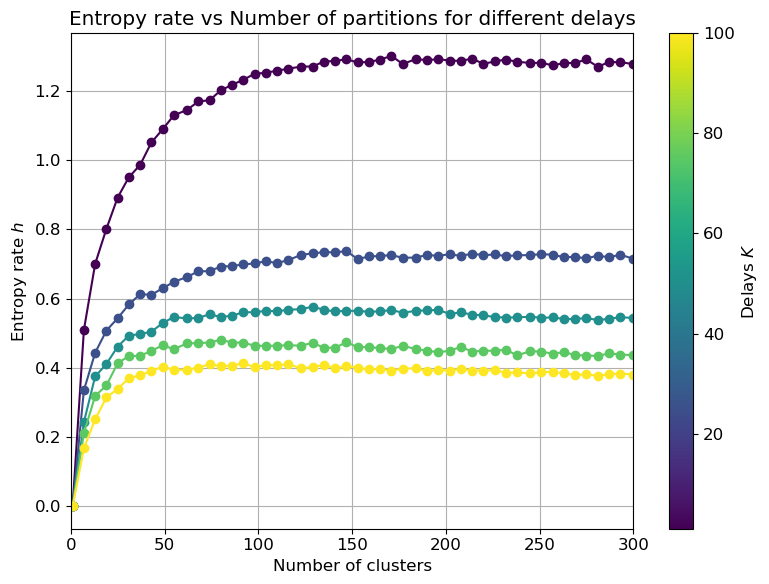

In [9]:
######################
#### Plot results ####
######################

# Normalize delays for color mapping
norm = mcolors.Normalize(vmin=min(Ks), vmax=max(Ks))
cmap = cm.viridis

# Plot
plt.figure(figsize=(8, 6))

for i, K in enumerate(Ks):
    color = cmap(norm(K))  # Map delay to color
    plt.plot(Ps, hs[i], marker='o', label=f'Delay={K}', color=color)

# Colorbar to show delay scale
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for Matplotlib < 3.1
cbar = plt.colorbar(sm)
cbar.set_label(r'Delays $K$')

plt.xlabel('Number of clusters')
plt.ylabel(r'Entropy rate $h$')
plt.title('Entropy rate vs Number of partitions for different delays')
#plt.legend(title="Delays")
plt.grid(True)
plt.xlim(0,300)
plt.tight_layout()
#plt.savefig('clusters.pdf')
plt.show()

### Now we look at delays only

In [10]:
# Set the range for number of delays
partitions = 150
Ks = np.linspace(1,200,100,dtype=int)

# Calculate entropy for each number of delays
hs = []
for K in Ks:
    hs.append(entropy_rate(trajectory_matrix(Xa_all,K=K-1), N=partitions))
    # print(hs)

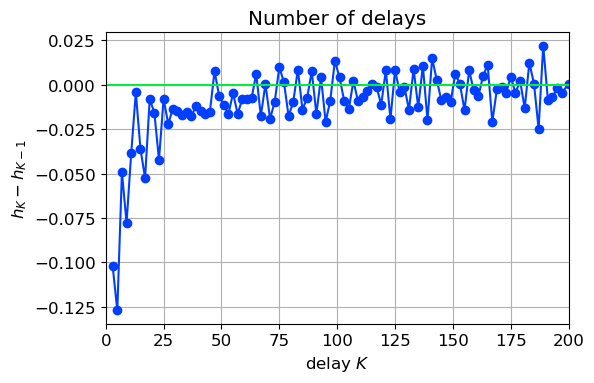

In [11]:
######################
#### Plot results ####
######################

# Calculate difference in entropy
differences = [hs[i] - hs[i-1] for i in range(1, len(hs))]
ones = [0]*len(Ks)

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(Ks[1:], differences, '-o')
plt.plot(Ks, ones, '-')
plt.ylabel('$h_{K} - h_{K-1}$')
plt.xlabel('delay $K$')
plt.grid(True)
plt.title('Number of delays')
plt.xlim(0,200)
plt.tight_layout()
#plt.savefig('delays.pdf')
plt.show()

## 4. Perform dimension reduction

### Start with PCA

In [12]:
K = 60
traj_matrix = trajectory_matrix(Xa_all,K=K-1)
Ni = traj_matrix.shape[0]

x_mean = np.mean(traj_matrix, axis=0)    # mean over data points
x_cent = traj_matrix - x_mean    # centered data
cov = np.dot(x_cent.T, x_cent) / (Ni - 1)   # covariance matrix

w, v = np.linalg.eig(cov)    # find eigenvalues and eigenvectors of covariance matrix

sort = np.argsort(w)[::-1]    # sort eigenvalues from largest to smallest
w = w[sort]
v = v[:,sort]    # sort eigenvectors accordingly

w = w / np.sum(w)    # normalized eigenvalues = variance along each principal component
wsum = np.cumsum(w)    # cumulative sum of normalized eigenvalues = variance captured

y_pca = np.dot(x_cent, v)

### Use the projection data to calculate entropy

In [13]:
# Set the range of dimensions
hs = []
dim = np.arange(2, 20)

# Calculate entropy for each added principal component
for i in range(1, 20):
    mat = y_pca[:,:i]
    hs.append(entropy_rate(mat, N=partitions))

# Calculate difference in entropy
differences = [hs[i] - hs[i-1] for i in range(1, len(hs))]

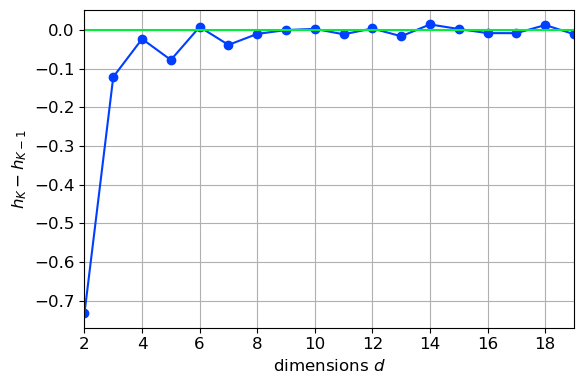

In [14]:
######################
#### Plot results ####
######################

x = np.arange(0, 20)
ones = [0]*len(x)

plt.figure(figsize=(6, 4))
plt.plot(dim, differences, '-o')
plt.plot(x, ones, '-')
plt.ylabel('$h_{K} - h_{K-1}$')
plt.xlabel('dimensions $d$')
plt.grid(True)
plt.xlim(2,19)
plt.tight_layout()
#plt.savefig('dimensions.pdf')
plt.show()

## 5. Define functions for Jacobian estimation and Lyapunov spectrum

In [15]:
def QR_decomp(Matrix):
    '''This fct does QR decomposition of the input matrix 
    and makes sure that the diagonal element of R are positive
    (This is conventional as the QR decomposition is not unique)'''
    Qmat,Rmat = np.linalg.qr(Matrix)
    Rdiag=np.diag(Rmat)
    for k in range(len(Rdiag)):
        if Rdiag[k]<0:
            Rmat[k,:]=-Rmat[k,:]
            Qmat[:,k]=-Qmat[:,k]
    return Qmat,Rmat

def estimate_lyap_exp(Ms,dt,L=1,N=3000):
    """
    Estimate the Lyapunov exponents using the estimated Jacobians stored in Ms. 
    """
    dim = Ms[0].shape[1]
    #Global flow
    Flow = np.identity(dim)
    Qhat = np.identity(dim)
    #local Jacobian at point data[0]
    M=Ms[0]
    #Using Q,R decomposition
    Q, R = QR_decomp(M)
    #Storing the Lyapunov exponents
    exponents = np.zeros(len(R))
    exps = []
    for i in range(1,N):
        M = Ms[i]
        Flow = np.dot(M,Flow)
        #Compute Lyapunov exponent
        if i % L == 0:
            Flow = np.linalg.multi_dot([Qhat.T, Flow, Qhat])
            Q, R = QR_decomp(Flow)
            exponents=exponents+np.log(np.diag(R))
            #Compute new Qhat
            Qhat = np.dot(Qhat,Q)
            #Reset the flow
            Flow = np.identity(dim)
            exps.append(exponents/(i*dt))
    return np.vstack(exps) / 60


def estimate_discrete_jac(X,epsilon,trange,small_weight_threshold=1e-3,T1=1):
    """
    Masks some Jacobians, so be aware that you need to calculate the exponents per segment!
    """
    Ms=ma.zeros((len(trange),X.shape[1],X.shape[1]))
    XX=X[:-T1,:]
    Xn=X[T1:,:]
    for ipred in trange:
        if XX[ipred].mask[0]==True:
            #print('masked',ipred)
            continue
        else:
            sel = np.ones(len(XX),dtype=bool)
            sel[ipred] = False
            dist = ma.sqrt((XX-XX[ipred])**2).sum(axis=1)

            wts = np.exp(-dist/epsilon)
            if ipred<10:
                wts[:ipred]=0
            elif len(wts)-ipred<10:
                wts[-ipred:]=0
            else:
                wts[ipred-10:ipred+10]=0
            wts = ma.masked_invalid(wts)
            wts[dist.mask] = ma.masked

            sel[wts/wts.max()<small_weight_threshold] = False
            sel[dist.mask] = False

            wts = wts[sel]
            z=np.hstack([np.ones(sel.sum()).reshape(-1,1),XX[sel]])
            zw = np.vstack([z[:,m]*wts for m in range(z.shape[1])]).T
            znw =  np.vstack([Xn[sel,m]*wts for m in range(Xn.shape[1])]).T
            A = np.linalg.pinv(zw).dot(znw)
            Ms[ipred] = A[1:].T
            #if ipred%100==0:
                #print(ipred)
    Ms[Ms==0] = ma.masked
    return Ms

## 6. Calculate Lyapunov spectrum

In [16]:
###################################
### Reconstruct the state space ###
###################################

d = 10
phspace = ma.array(y_pca[:, :d])
phspace[phspace==0] = ma.masked


##############################
### Estimate the Jacobians ###
##############################

trange = np.arange(len(phspace)-1)
epsilon = 2.85
Jac = estimate_discrete_jac(phspace,epsilon,trange)


#######################################
### Calculate exponents per segment ###
#######################################

mask = ~phspace[:,0].mask
segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)

exps_seg=[]
for idx in range(len(segments)):
    """
    exponents per segment
    """
    t0,tf = segments[idx]
    Jac_sample = Jac[t0:tf]
    exps = estimate_lyap_exp(Jac_sample, new_dt, N=len(Jac_sample))
    exps_seg.append(exps)
#     print(idx)

In [17]:
# Add the exponents of each segment to each other
exps_all = np.vstack([exps[-3000:] for exps in exps_seg])

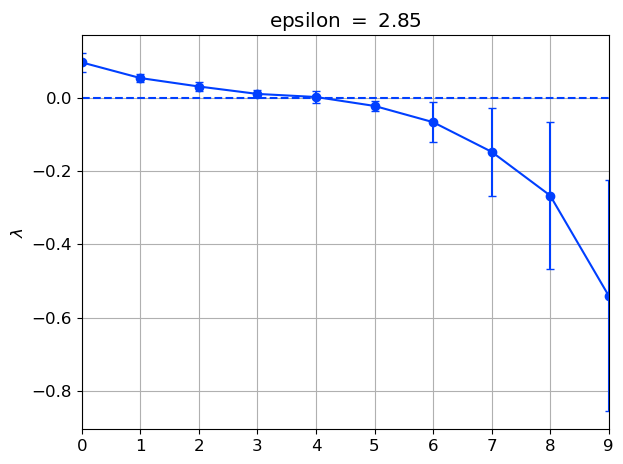

In [18]:
####################
### Plot results ###
####################

plt.errorbar(np.arange(d), exps_all.mean(axis=0), yerr = exps_all.std(axis=0),capsize=3,fmt='o-')
plt.axhline(0,ls='--')
plt.title(r'epsilon $=$ %1.2f' %epsilon)
plt.grid(True)
plt.xlim(0, 9)
plt.ylabel(r"$\lambda$")
plt.tight_layout()
#plt.savefig('spectrum_datadriven4.pdf')
plt.show()

### Calculate Kaplan-Yorke dimension

In [19]:
def KY_dimension(lyap):
    sum_lyap = 0

    for i in range(len(lyap)):
        sum_lyap_new = sum_lyap + lyap[i]

        if sum_lyap_new < 0:
            KY = i + sum_lyap / abs(lyap[i])
            break
        else:
            sum_lyap = sum_lyap_new

    return KY

In [20]:
print('Kaplan-Yorke dimension is', KY_dimension(exps_all.mean(axis=0)))
print('Largest Lyapunov exponent is', max(exps_all.mean(axis=0)))
print('Lyapunoc spectrum is', exps_all.mean(axis=0))

Kaplan-Yorke dimension is 7.694392835512424
Largest Lyapunov exponent is 0.09608478905042853
Lyapunoc spectrum is [ 0.09608479  0.05344319  0.03038297  0.01017477  0.00176312 -0.02260249
 -0.0667781  -0.14756525 -0.26676017 -0.53985328]
